# Imports

In [1]:
from DeepRedshift.figures import (
    scatter_plot_eval,
    error_plot_eval,
    loss_eval,
    report_plot
)
from DeepRedshift.dataset import QuasarDataset
from DeepRedshift.models import (
    FCVanilla,
    FCBatchNormDropout,
    CNNVanilla,
    CNNDeep
)
from DeepRedshift.experiment_train import model_try
from DeepRedshift.utils import rebin_data

import glob
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import wandb

# Pytroch stuff
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, optim
from torchinfo import summary

# Show selected GPU
gpu_idx = torch.cuda.current_device()
print(torch.cuda.get_device_properties(gpu_idx))

wv = pd.read_csv('data/QSOs/0.csv')['wave'].values

# For reproducibility
torch.manual_seed(42)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Wandb config
os.environ["WANDB_SILENT"] = "true"

sns.set_theme()
# Logger
logger = logging.getLogger('wandb')
logger.setLevel(logging.ERROR)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060 Laptop GPU', major=8, minor=6, total_memory=6143MB, multi_processor_count=30)


# Pre-process data 

In [2]:
# Read from pkls
df = pd.read_pickle('data/data.pkl')

In [3]:
df.head(3)

,flux_full,Z,flux_b,wave_b,flux_r,wave_r,flux_z,wave_z
50130291,5.5749,1.847688,"[6.316943645477295, 4.637505054473877, 4.45759...","[3569.39990234375, 3570.39990234375, 3571.3999...","[0.8951932787895203, -0.48711779713630676, 6.2...","[5625.39990234375, 5626.39990234375, 5627.3999...","[1.343870759010315, 2.467992067337036, 4.08662...","[7435.39990234375, 7436.39990234375, 7437.3999..."
50130304,4.427626,1.817459,"[3.4335825443267822, 1.9359098672866821, 3.305...","[3569.39990234375, 3570.39990234375, 3571.3999...","[-1.2831424474716187, -0.7486328482627869, 0.2...","[5625.39990234375, 5626.39990234375, 5627.3999...","[0.5637927651405334, 1.4473059177398682, 2.588...","[7435.39990234375, 7436.39990234375, 7437.3999..."
50130318,4.652752,1.940764,"[22.567916870117188, 24.14146614074707, 19.105...","[3569.39990234375, 3570.39990234375, 3571.3999...","[0.07029576599597931, -7.117312908172607, -3.0...","[5625.39990234375, 5626.39990234375, 5627.3999...","[2.164449691772461, 0.7670164704322815, -1.800...","[7435.39990234375, 7436.39990234375, 7437.3999..."


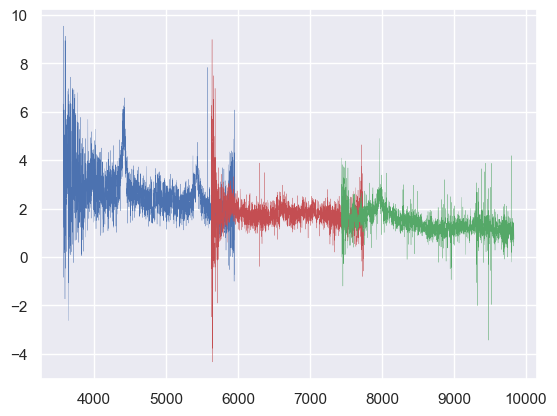

In [4]:
df_row = df.iloc[0]

flux_b = df_row['flux_b']
wave_b = df_row['wave_b']
flux_r = df_row['flux_r']
wave_r = df_row['wave_r']
flux_z = df_row['flux_z']
wave_z = df_row['wave_z']

plt.plot(wave_b, flux_b, color = 'b', linewidth = 0.2)
plt.plot(wave_r, flux_r, color = 'r', linewidth = 0.2)
plt.plot(wave_z, flux_z, color = 'g', linewidth = 0.2)

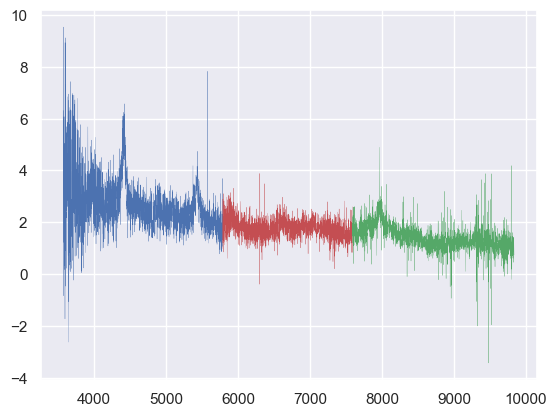

In [5]:
delta_br = (wave_b[-1] + wave_r[0]) / 2
delta_rz = (wave_r[-1] + wave_z[0]) / 2

flux_b = flux_b[:np.where(delta_br < wave_b)[0][0]]
wave_b = wave_b[:np.where(delta_br < wave_b)[0][0]]

flux_r = flux_r[np.where(delta_br > wave_r)[0][-1]:np.where(delta_rz < wave_r)[0][0]]
wave_r = wave_r[np.where(delta_br > wave_r)[0][-1]:np.where(delta_rz < wave_r)[0][0]]

flux_z = flux_z[np.where(delta_rz > wave_z)[0][-1]:]
wave_z = wave_z[np.where(delta_rz > wave_z)[0][-1]:]

plt.plot(wave_b, flux_b, color = 'b', linewidth = 0.2)
plt.plot(wave_r, flux_r, color = 'r', linewidth = 0.2)
plt.plot(wave_z, flux_z, color = 'g', linewidth = 0.2)

(6267,)


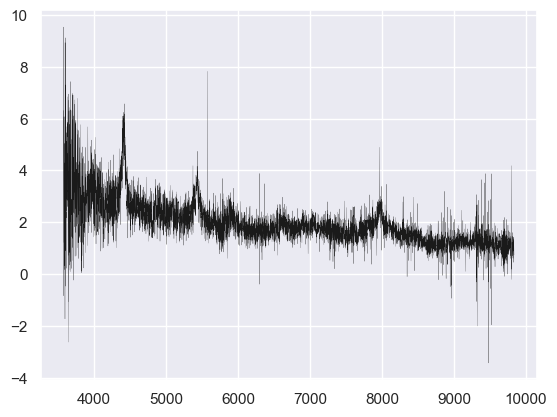

In [6]:
# Concatenate
flux = np.concatenate((flux_b, flux_r, flux_z))
wave = np.concatenate((wave_b, wave_r, wave_z))

plt.plot(wave, flux, color = 'k', linewidth = 0.15)
print(flux.shape)

In [7]:
Z = []
ids = []
flux_full = []
flux = []
wv = []

for i in tqdm(range(0, len(df))):
    df_row = df.iloc[i]

    flux_b = df_row['flux_b']
    wave_b = df_row['wave_b']
    flux_r = df_row['flux_r']
    wave_r = df_row['wave_r']
    flux_z = df_row['flux_z']
    wave_z = df_row['wave_z']
    Z.append(df_row['Z'])
    ids.append(df_row.name)
    flux_full.append(df_row['flux_full'])

    delta_br = (wave_b[-1] + wave_r[0]) / 2
    delta_rz = (wave_r[-1] + wave_z[0]) / 2

    flux_b = flux_b[:np.where(delta_br < wave_b)[0][0]]
    wave_b = wave_b[:np.where(delta_br < wave_b)[0][0]]
    flux_r = flux_r[np.where(delta_br > wave_r)[0][-1]:np.where(delta_rz < wave_r)[0][0]]
    wave_r = wave_r[np.where(delta_br > wave_r)[0][-1]:np.where(delta_rz < wave_r)[0][0]]
    flux_z = flux_z[np.where(delta_rz > wave_z)[0][-1]:]
    wave_z = wave_z[np.where(delta_rz > wave_z)[0][-1]:]

    flux_i = np.concatenate((flux_b, flux_r, flux_z))
    wave_i = np.concatenate((wave_b, wave_r, wave_z))

    flux.append(flux_i)
    wv.append(wave_i)

100%|██████████| 40000/40000 [00:06<00:00, 6164.79it/s]


In [8]:
# Save data to pkl
data = {'id': ids, 'Z': Z, 'flux_full': flux_full, 'flux': flux, 'wave': wv}
df = pd.DataFrame(data)
df.head()

,id,Z,flux_full,flux,wave
0,50130291,1.847688,5.574900,"[6.316943645477295, 4.637505054473877, 4.45759...","[3569.39990234375, 3570.39990234375, 3571.3999..."
1,50130304,1.817459,4.427626,"[3.4335825443267822, 1.9359098672866821, 3.305...","[3569.39990234375, 3570.39990234375, 3571.3999..."
2,50130318,1.940764,4.652752,"[22.567916870117188, 24.14146614074707, 19.105...","[3569.39990234375, 3570.39990234375, 3571.3999..."
3,50130322,2.279219,4.309511,"[3.3110246658325195, 1.6816339492797852, 9.821...","[3569.39990234375, 3570.39990234375, 3571.3999..."
4,50130325,2.290676,12.221321,"[1.4321434497833252, 13.602473258972168, 2.557...","[3569.39990234375, 3570.39990234375, 3571.3999..."


In [9]:
# If data is not saved
if not os.path.exists('data/data_ready.pkl'):
    df.to_pickle('data/data_ready.pkl')

## Resample the data

In [2]:
# Print current bin size and data shape
print(f'Current bin size: {wv[0][1] - wv[0][0]:.3f}')
print(f'Current data shape: {flux[0].shape}')

# New bin size
new_bin_size = 8.0

# Rebin data
wv_example, flux_example = rebin_data(wv[0], np.array([flux[0]]), bin_size = new_bin_size)

# Print new bin size and data shape
print(f'New bin size: {wv_example[1] - wv_example[0]:.3f}')
print(f'New data shape: {flux_example[0].shape}')

# Plot new data and old data
plt.plot(wv_example, flux_example[0], linewidth = 0.8, zorder = 5, label = 'Rebinned', color = 'black')
plt.plot(wv[0], flux[0], linewidth = 0.1, alpha = 0.8, label = 'Original')
plt.legend()
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.title('Example of rebinning data - From 0.1 Å to 10 Å')
plt.show()

IndexError: invalid index to scalar variable.

In [11]:
# Rebinn all data

# if dont exist, create
if not os.path.exists('data/data_rebinned.pkl'):
    # Copy dataframe
    df_rebinned = df.copy()

    # Apply rebinning function
    df_rebinned['wave_rebinned'] = df_rebinned.apply(lambda x: rebin_data(x['wave'], np.array([x['flux']]), bin_size = 10.0)[0], axis = 1)
    df_rebinned['flux_rebinned'] = df_rebinned.apply(lambda x: rebin_data(x['wave'], np.array([x['flux']]), bin_size = 10.0)[1][0], axis = 1)

    # Drop old columns
    df_rebinned = df_rebinned.drop(columns = ['wave', 'flux'])

    # Rename columns
    df_rebinned = df_rebinned.rename(columns = {'wave_rebinned': 'wave', 'flux_rebinned': 'flux'})

    # Save dataframe to pkl
    df_rebinned.to_pickle('data/data_rebinned.pkl')

    del df_rebinned

del df

# Create Pytorch dataset

In [2]:
# Create dataset
dataset = QuasarDataset(data_path='data/data_ready.pkl')

# Train/val/test split
train_set, val_set, test_set = random_split(dataset, [0.8, 0.1, 0.1])

print(f'Size of train set: {len(train_set)}')
print(f'Size of validation set: {len(val_set)}')
print(f'Size of test set: {len(test_set)}')

Size of train set: 32000
Size of validation set: 4000
Size of test set: 4000


In [3]:
# Rebinned dataset
dataset_rebinned = QuasarDataset(data_path='data/data_rebinned.pkl')

# Train/val/test split
train_set_rebin, val_set_rebin, test_set_rebin = random_split(dataset_rebinned, [0.8, 0.1, 0.1])

print(f'Size of train set: {len(train_set_rebin)}')
print(f'Size of validation set: {len(val_set_rebin)}')
print(f'Size of test set: {len(test_set_rebin)}')

Size of train set: 32000
Size of validation set: 4000
Size of test set: 4000


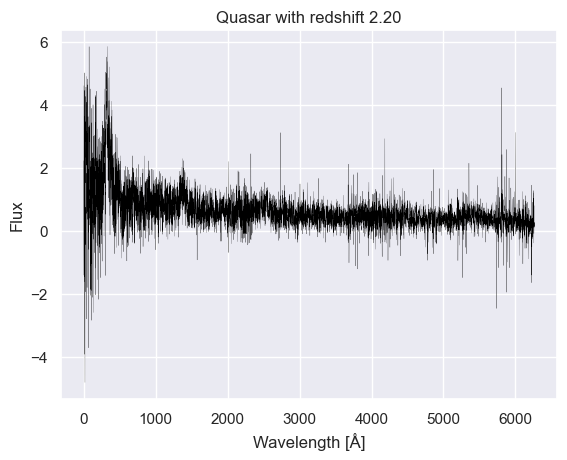

Shape of quasar: (6267,)
Size of dataset: 40000


In [4]:
# Example
quasar, label = dataset[5]

plt.plot(quasar, linewidth=0.15, color = 'black')
plt.title(f'Quasar with redshift {label:.2f}')
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux')
plt.show()

print(f'Shape of quasar: {quasar.shape}')
print(f'Size of dataset: {len(dataset)}')

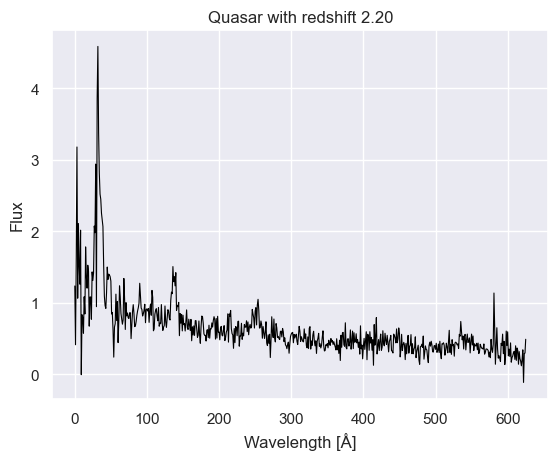

Shape of quasar: (626,)
Size of dataset: 40000


In [5]:
# Example
quasar, label = dataset_rebinned[5]

plt.plot(quasar, color = 'black', linewidth = 0.8)
plt.title(f'Quasar with redshift {label:.2f}')
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux')
plt.show()

print(f'Shape of quasar: {quasar.shape}')
print(f'Size of dataset: {len(dataset)}')

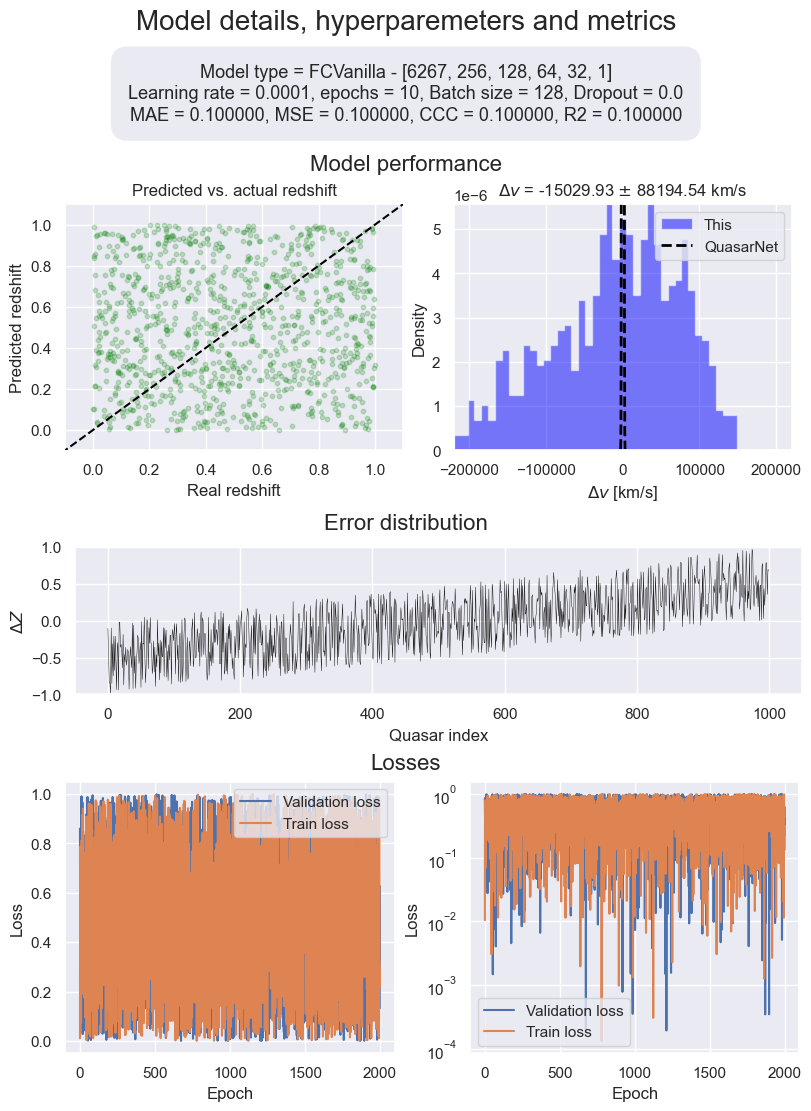

In [6]:
# Random values
labels = np.random.rand(1000)
predictions = np.random.rand(1000)
val_loss = np.random.rand(2000)
train_loss = np.random.rand(2000)

config_fc = {
    'epochs': 10,
    'batch_size': 128,
    'learning_rate': 0.0001,
    'dropout': 0.0,
    'model_type': 'FCVanilla',
    'layers_dims': [6267, 256, 128, 64, 32, 1]
}

metrics_values = {
    'mae': 0.1,
    'mse': 0.1,
    'ccc': 0.1,
    'r2': 0.1
}

report = report_plot(labels, predictions, train_loss, val_loss, config_fc, metrics_values)

In [7]:
# Plumbing all the models
model_fc_vanilla = FCVanilla(layers_dims=[6267, 1024, 256, 64, 16, 1])
model_fc_batchnorm_dropout = FCBatchNormDropout(layers_dims=[6267, 1024, 256, 64, 16, 1], dropout=0.2)

x = torch.randn(10, 6267, dtype = torch.float32)
try:
    model_fc_vanilla(x)
    model_fc_batchnorm_dropout(x)
except Exception as e:
    print(e)

In [8]:
# Ploombing the models with random data
x = torch.randn(10, 6267, dtype = torch.float32)

model_cnn_vanilla = CNNVanilla()
model_cnn_deep = CNNDeep()

try:
    model_cnn_vanilla(x)
    model_cnn_deep(x)
    print("Success!")
except Exception as e:
    print(e)

Success!


In [9]:
config_fc_template = {
    'epochs': 100,
    'batch_size': 64,
    'learning_rate': 0.001,
    'dropout': 0.0,
    'model_type': 'FCVanilla',
    'layers_dims': [6267, 256, 128, 64, 32, 1]
}

# Fully connected network

100%|██████████| 10/10 [00:28<00:00,  2.84s/it]


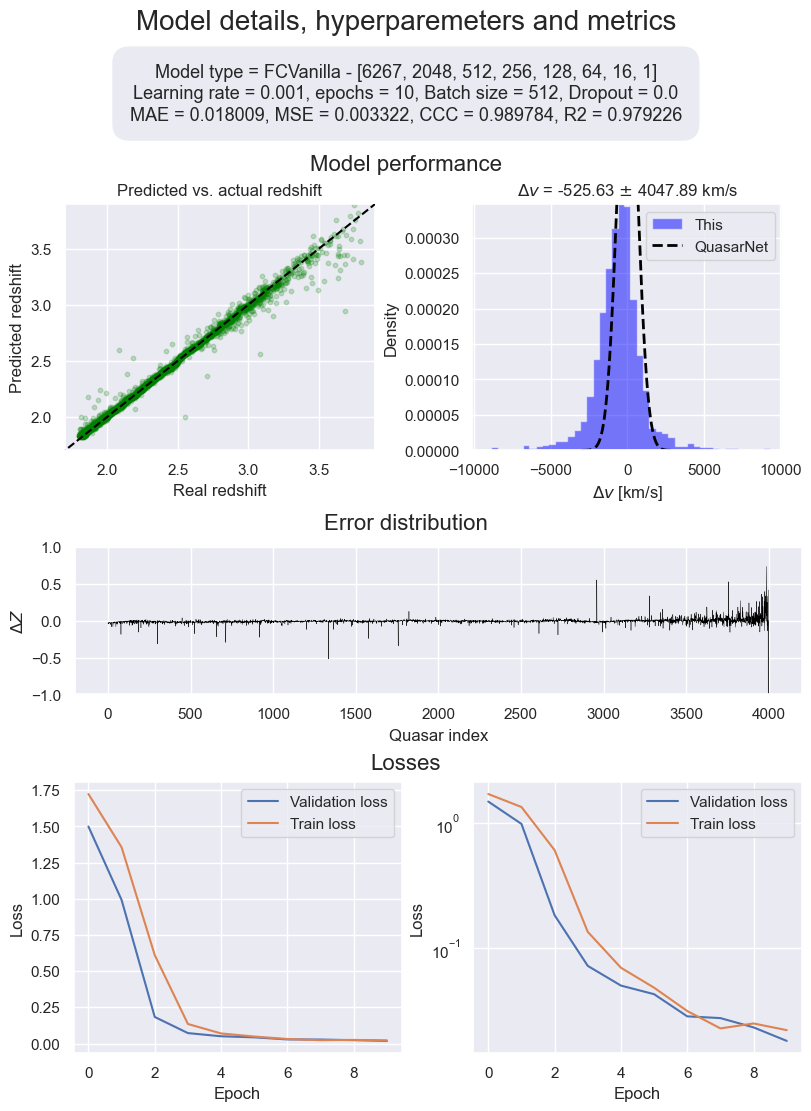

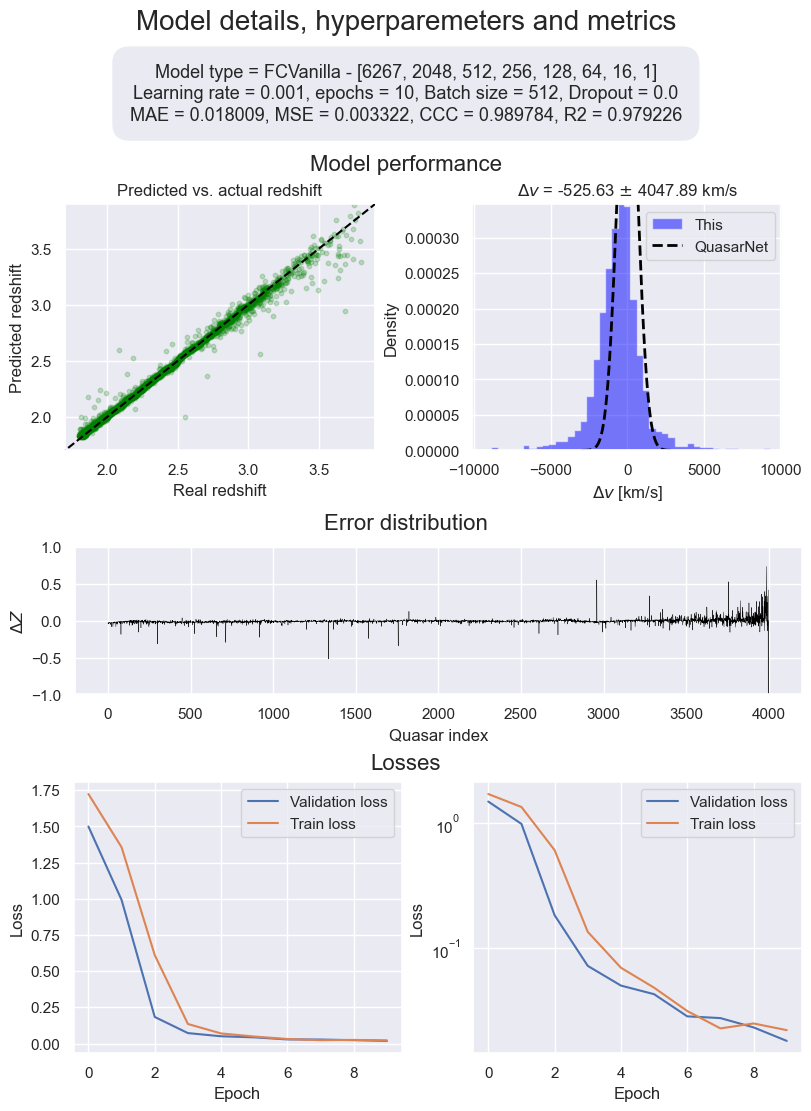

In [10]:
config_fc = {
    'epochs': 10,
    'batch_size': 512,
    'learning_rate': 0.001,
    'dropout': 0.0,
    'model_type': 'FCVanilla',
    'layers_dims': [6267, 2048, 512, 256, 128, 64, 16, 1]
}

# Create model with seed
torch.manual_seed(42)
model = FCVanilla(config_fc['layers_dims'])
model_try(config_fc, model, train_set, val_set)

In [ ]:
config_fc = {
    'epochs': 60,
    'batch_size': 256,
    'learning_rate': 0.001,
    'dropout': 0.0,
    'model_type': 'FCVanilla',
    'layers_dims': [6267, 4096, 2048, 1024, 512, 256, 128, 64, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 16, 1]
}

# Create model with seed
torch.manual_seed(42)
model = FCVanilla(config_fc['layers_dims'])
model_try(config_fc, model, train_set, val_set)

In [ ]:
# 36 Modelos diferentes!
possible_epochs = [50]
possible_batch_sizes = [64, 128, 256]
possible_learning_rates = [0.001, 0.0005, 0.0001]
possible_layers_dims = [
    [6267,4096,2048,1024,512,256,128,64,32,1],
    [6267,4096,2048,1024,512,256,128,64,64,64,64,64,64,64,64,64,64,64,32,1],
    [6267,4096,2048,1024,512,256,128,64,32,32,32,32,32,32,32,32,32,32,16,1],
    [6267,4096,2048,2048,1024,1024,512,512,512,256,256,256,128,128,128,128,64,64,64,64,32,32,32,32,1],
]

for epochs in possible_epochs:
    for batch_size in possible_batch_sizes:
        for learning_rate in possible_learning_rates:
            for layers_dims in possible_layers_dims:
                config_fc = {
                    'epochs': epochs,
                    'batch_size': batch_size,
                    'learning_rate': learning_rate,
                    'dropout': 0.0,
                    'model_type': 'FCVanilla',
                    'layers_dims': layers_dims
                }

                # Create model with seed
                torch.manual_seed(42)
                model = FCVanilla(config_fc['layers_dims'])
                model_try(config_fc, model, train_set, val_set)

### Try in rebin data

In [ ]:
config_fc = {
    'epochs': 60,
    'batch_size': 128,
    'learning_rate': 0.0005,
    'dropout': 0.0,
    'model_type': 'FCVanilla_rebin',
    'layers_dims': [6267,4096,2048,1024,512,256,128,64,64,64,64,64,64,64,64,64,64,64,32,1]
}

# Create model with seed
model = FCVanilla(config_fc['layers_dims'])
model_try(config_fc, model, train_set_rebin, val_set_rebin)

### Try with BatchNorm and Dropout (whithout rebin)

In [ ]:
config_fc = {
    'epochs': 60,
    'batch_size': 128,
    'learning_rate': 0.0005,
    'dropout': 0.0,
    'model_type': 'FCBatchNormDropout',
    'layers_dims': [6267,4096,2048,1024,512,256,128,64,64,64,64,64,64,64,64,64,64,64,32,1]
}

# Create model with seed
model = FCBatchNormDropout(config_fc['layers_dims'])
model_try(config_fc, model, train_set, val_set)

# Convolutional neural network

In [22]:
class QuasarNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.type = 'CNNVanilla'
        self.flatten = nn.Flatten()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels = 100, kernel_size = 10, stride = 2, padding = 'valid'),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Conv1d(in_channels = 100, out_channels = 100, kernel_size = 10, stride = 2, padding = 'valid'),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Conv1d(in_channels = 100, out_channels = 100, kernel_size = 10, stride = 2, padding = 'valid'),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Conv1d(in_channels = 100, out_channels = 100, kernel_size = 10, stride = 2, padding = 'valid'),
            nn.BatchNorm1d(100),
            nn.ReLU(),
        )
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3100, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):

        # Add empty channel dimension
        x = x.unsqueeze(1)

        x = self.conv_relu_stack(x)

        x = self.flatten(x)

        logits = self.linear_relu_stack(x)
        return logits

# Ploombing the models with random data
x = torch.randn(10, 626, dtype = torch.float32)

model_cnn_vanilla = QuasarNet()

try:
    model_cnn_vanilla(x)
    print("Success!")
except Exception as e:
    print(e)

Success!


- We downsample them to 443 pixels, also equally spaced in logwavelength between the same limits. Large variations in the
inputs to neural networks, in our case due to the distribution
of quasar luminosity, are known to slow down learning.
- Batch size of 256
- Adam for optimization
- 100 epochs
- 5 convolutional layers ()
- 80/20 train/test split
- Layers: Neural Network architecture. Layers 1-4 are convolutional layers of 100 filters of size 10 and strides of 2 and rectified
linear unit (ReLU) activations. Layer 5 is a fully connected layer
of size 100 and a sigmoid activation.
- $v = zc$, $\Delta v = (8 \pm 664)km/s$

In [ ]:
config_fc = {
    'epochs': 20,
    'batch_size': 256,
    'learning_rate': 0.001,
    'dropout': 0.0,
    'model_type': 'CNNVanilla_rebin',
    'layers_dims': 'Default'
}

model = QuasarNet()
model_try(config_fc, model, train_set_rebin, val_set_rebin)